This is an exercise to analyse and predict passenger data for the Metropolitan Transit Authority (NYC).

### Initial findings
- We can see quite a clear weekly trend, with weekends having much fewer passengers than weekdays, as one might expect.
- Entries and exits also look quite different, with exits happening in the morning and entries happening in the evening (presumably corresponding to people going to work and going home respectively). It might make sense to separate this into 2 distinct prediction problems, given the stark difference between these variables.
- There is a sudden large drop in early 2020, corresponding to the COVID pandemic. This represents a significant shift in the data that extends for the entire rest of the time period and makes it much harder to create an accurate model. Given the time when the model was created (end of 2020), it wouldn't really have been viable to exclude pre-COVID data. As expected, the initial models that just use some date features failed to capture this shift. Subsequent models perform much better thanks to including shifted recent data.

### Data problems
- Daily passengers has outliers that is likely a data problem. If these were, for example, particularly busy days, we'd expect a more balanced distribution up to those values, instead of these being large spikes with other values being barely visible in comparison.
- Device count has some suspicious dips. It's unclear if this is a data problem, or if this accurately reflects what the actual device count was. It could be that the default devices is 17, but some are switched off or malfunction at various times, and this happens in batches (e.g. power outages might affect a number of devices at the same time).
- The recorded hour count is suspiciously often a multiple of 4 (or a multiple of 4 minus 1). A crude way to deal with this might be to round the hour to a multiple of 4.

### Which metric to use?
- **Mean absolute error:** Quite common. But one issue is that large values dominate the error: 1100 predict vs 1000 actual is treated the same as 200 predict vs 100 actual, despite the former being a 10% difference and the latter being a 100% difference. This would make it difficult to compare the performance of stations with different volumes.
- **Mean absolute percentage error:** This has the opposite problem that 2000 predict vs 1000 actual is treated the same as 20 predict vs 10 actual. Our prediction being off by 1000 passengers may be a huge problem, whereas we may not really care about an error of merely 10 passengers. One way to mitigate this could be to have some minimum threshold.

### What are the real-world implications of over- and under-predicting?
- Unnecessary or insufficient staff
- Long queue waiting time
- Unexpected expenses given a fixed dollar cost per passenger
- Passengers might exceed maximum capacity
- This might affect service-level agreements, which could result in significant penalties if predictions are inaccurate

### Potential next steps
- Improve data engineering
	- Make it work for all stations
- Use daily instead of hourly data from the last week (or just the average)
- Extend training data beyond 1 year
- Include external data (weather, holidays, events)
- Experiment with other models
- Tune hyperparameters
- Build a combined model for stations
- Maybe build a model for new stations

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

# Format: "http://web.mta.info/developers/data/nyct/turnstile/turnstile_YYMMDD.txt"
source_prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
source_suffix = ".txt"

file_prefix = "data/"
file_suffix = ".csv"

start_date = dt.date(2019, 1, 5)
end_date = dt.date(2020, 12, 12)

def copy_data_from_server(start, end):
    for current in pd.date_range(start, end, freq="7D"):
        date_str = f"{current.year % 100:02d}{current.month:02d}{current.day:02d}"
        df = pd.read_csv(source_prefix + date_str + source_suffix)
        df.to_csv(file_prefix + date_str + file_suffix, index=False)

# Takes a while
# copy_data_from_server(start_date, end_date)

In [ ]:
def create_year_files():
    base = []
    last_year = start_date.year
    for current in pd.date_range(start_date, end_date, freq="7D"):
        if current.year != last_year:
            pd.concat(base).to_csv(file_prefix + "year" + str(last_year) + file_suffix, index=False)
            base = []
        date_str = f"{current.year % 100:02d}{current.month:02d}{current.day:02d}"
        df = pd.read_csv(file_prefix + date_str + file_suffix)
        df.columns = df.columns.to_series().replace({"^EXITS\\s*$": "EXITS"}, regex=True)
        df = df[["SCP", "STATION", "DATE", "TIME", "ENTRIES", "EXITS"]]
        # filter stations we care about
        # df = df[df["STATION"].apply(lambda x: x in stations)]
        base.append(df)
        print("Read", current, " with rows:", df.shape[0])
        last_year = current.year

    pd.concat(base).to_csv(file_prefix + "year" + str(last_year) + file_suffix, index=False)

# Takes a while
# create_year_files()

In [ ]:
df = pd.read_csv(file_prefix + "year2019" + file_suffix)

df = df.groupby("STATION").sum()

df["COMBINED"] = df["ENTRIES"] + df["EXITS"]
df = df.groupby("STATION").sum().sort_values("ENTRIES", ascending=False)

df = df.iloc[[x + i * (df.shape[0] // 4) for i in range(4) for x in range(20)]]
potential_stations = list(df.index)

df

ENTRIES           EXITS        COMBINED
STATION                                                        
42 ST-PORT AUTH  17188241513083  14146077859330  31334319372413
125 ST           13481564479389   8183026564416  21664591043805
TIMES SQ-42 ST   13058905260947  10104697163203  23163602424150
23 ST            12629695032669  12055395526309  24685090558978
CHAMBERS ST      10532828496815   8615616241134  19148444737949
...                         ...             ...             ...
NASSAU AV           29452566037     23307825651     52760391688
ELDER AV            28285345595     27540817304     55826162899
AVENUE X            28280555407     25376865989     53657421396
NORWOOD AV          28095920853     30530030882     58625951735
55 ST               27833318832     20101407929     47934726761

[80 rows x 3 columns]

In [643]:
new_stations = [
    "183 ST",
    "59 ST COLUMBUS",

    "CENTRAL PK N110",
    "FT HAMILTON PKY",

    "40 ST LOWERY ST",
    "63 DR-REGO PARK",

    "174-175 STS",
    "LONGWOOD AV"
]

print("Selected station quartiles:", [4 * potential_stations.index(station) // len(potential_stations) for station in new_stations])

stations = set(new_stations)

Selected station quartiles: [0, 0, 1, 1, 2, 2, 3, 3]


In [ ]:
def read_csv(date_str):
    df = pd.read_csv(file_prefix + date_str + file_suffix, parse_dates=[["DATE", "TIME"]], keep_date_col=True)
    df.columns = df.columns.to_series().replace({"^EXITS\\s*$": "EXITS"}, regex=True)
    return df

station = "BROOKLYN BRIDGE"

def plot_passengers(df, title):
    df["PASSENGERS"].plot(xlabel="Date", ylabel="Passengers", title=title)

df = read_csv("190302")
df = df[df["STATION"] == station]
df["PASSENGERS"] = df["ENTRIES"] + df["EXITS"]

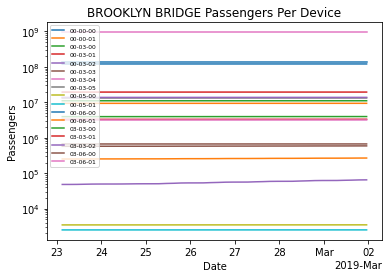

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

for device in sorted(df["SCP"].value_counts().index):
    plt.plot("DATE_TIME", "PASSENGERS", data=df[df["SCP"] == device], label=device)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Passengers")
plt.legend(loc="upper left", fontsize=6)
plt.title(f"{station} Passengers Per Device")
plt.show()

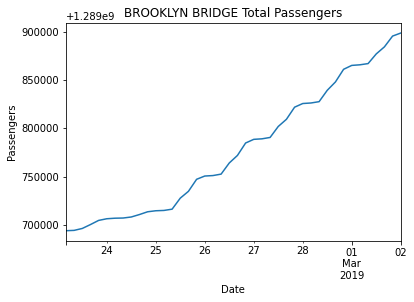

In [ ]:
df2 = df.copy()

df2["DATE_TIME"] = df2["DATE_TIME"].apply(lambda x: x + pd.Timedelta(hours=4 * ((x.hour+2) // 4) - x.hour))
df2 = df2.groupby(["SCP", "DATE_TIME"], as_index=False).mean()

df_summed = df2.groupby("DATE_TIME").sum()
plot_passengers(df_summed, f"{station} Total Passengers")

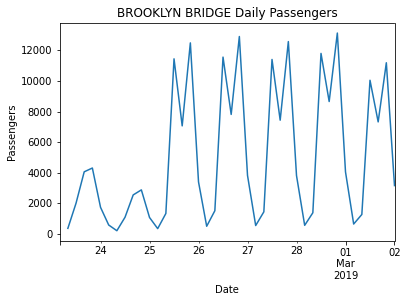

In [ ]:
df_diff = df_summed.copy()

for col in ["PASSENGERS", "ENTRIES", "EXITS"]:
    df_diff[col] = df_diff[col] - df_diff[col].shift(1)
plot_passengers(df_diff, f"{station} Daily Passengers")

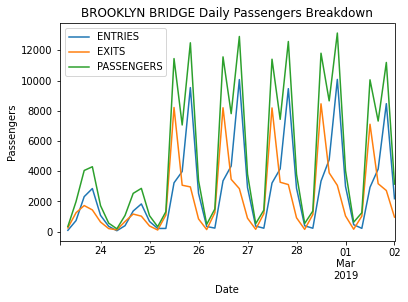

In [ ]:
_ = df_diff.rename(columns={station: "SUM"}).plot(xlabel="Date", ylabel="Passengers", title=f"{station} Daily Passengers Breakdown")

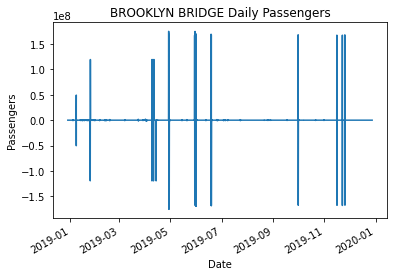

In [682]:
df = read_csv("year2019")
df = df[df["STATION"] == station]

df2 = df.groupby("DATE_TIME").sum()
df2["PASSENGERS"] = df2["ENTRIES"] - df2["EXITS"]
df2["PASSENGERS"] = df2["PASSENGERS"] - df2["PASSENGERS"].shift(1)

plot_passengers(df2, f"{station} Daily Passengers")

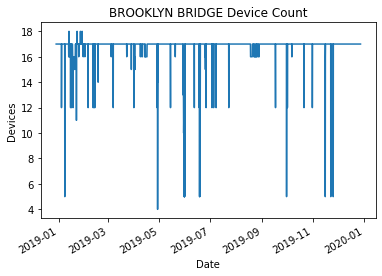

In [ ]:
df2 = df.groupby("DATE_TIME").count()
_ = df2["SCP"].plot(xlabel="Date", ylabel="Devices", title=f"{station} Device Count")

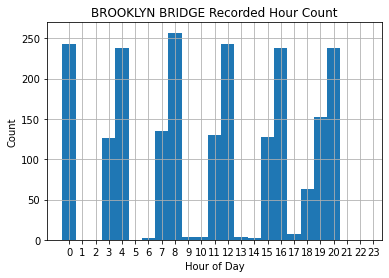

In [ ]:
df2 = df.groupby("DATE_TIME").sum()
df2["HOUR"] = df2.index.hour
ax = df2["HOUR"].hist(bins=np.arange(24)-0.5)
ax.set(xlabel="Hour of Day", ylabel="Count", title=f"{station} Recorded Hour Count")
_ = plt.xticks(range(24))

In [ ]:
import calendar

def hour_counts(df):
    df = df.index.month.value_counts().sort_index()
    df.index = df.index.map(lambda x: calendar.month_name[x])
    return df

print("Hour is multiple of 4:")
print(hour_counts(df2[df2.index.hour % 4 == 0]))
print()

print("Hour+1 is multiple of 4:")
print(hour_counts(df2[(df2.index.hour+1) % 4 == 0]))

Hour is multiple of 4:
January        3
February       2
March        132
April        181
May          193
June         183
July         191
August       186
September    183
October      188
November      15
Name: DATE_TIME, dtype: int64

Hour+1 is multiple of 4:
January      188
February     169
March         54
May           24
June           9
September      2
November     171
December     180
Name: DATE_TIME, dtype: int64


Went from 2337 to 2174 entries


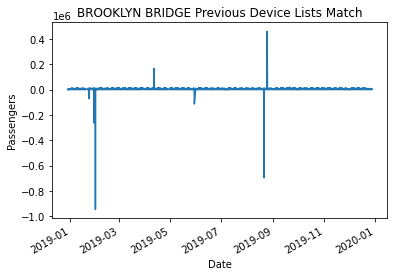

In [ ]:
df2 = df.groupby("DATE_TIME").agg(
    ENTRIES=pd.NamedAgg(column="ENTRIES", aggfunc=list),
    EXITS=pd.NamedAgg(column="EXITS", aggfunc=list),
    SCP=pd.NamedAgg(column="SCP", aggfunc=list))

for col in ["ENTRIES", "EXITS", "SCP"]:
    df2[col + "_PREV"] = df2[col].shift(1)

old_count = df2.shape[0]

df2 = df2[df2.apply(lambda x: x["SCP"] == x["SCP_PREV"], axis=1)]

print("Went from", old_count, "to", df2.shape[0], "entries")

df2["ENTRIES"] = df2.apply(lambda x: sum(x["ENTRIES"]) - sum(x["ENTRIES_PREV"]), axis=1)
df2["EXITS"] = df2.apply(lambda x: sum(x["EXITS"]) - sum(x["EXITS_PREV"]), axis=1)
df2["PASSENGERS"] = df2["ENTRIES"] + df2["EXITS"]

plot_passengers(df2, f"{station} Previous Device Lists Match")

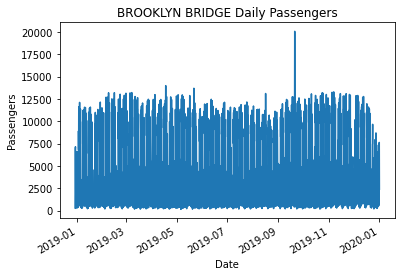

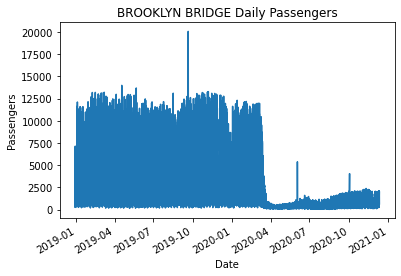

0 CENTRAL PK N110


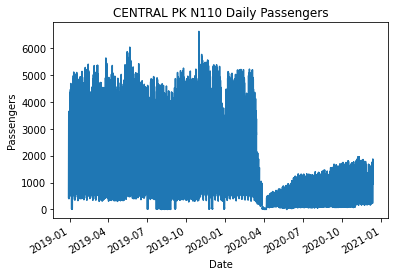

1 FT HAMILTON PKY


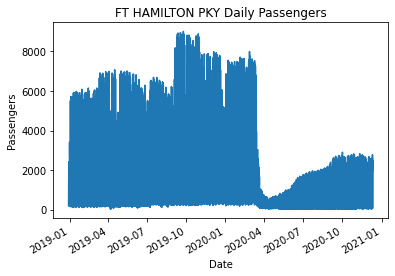

2 63 DR-REGO PARK


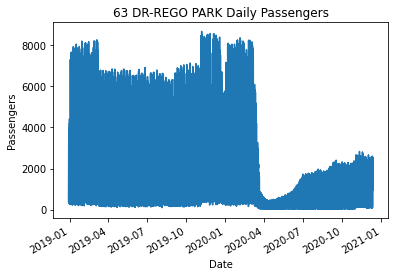

3 LONGWOOD AV


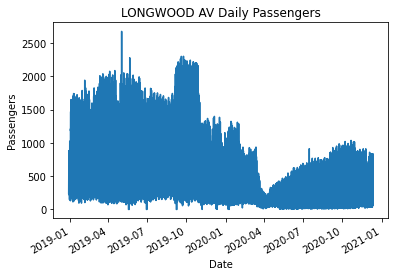

4 174-175 STS


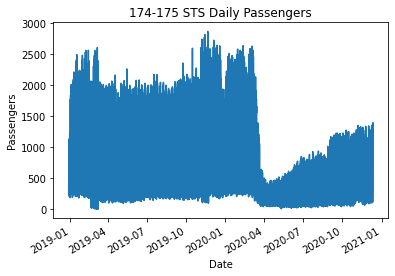

5 183 ST


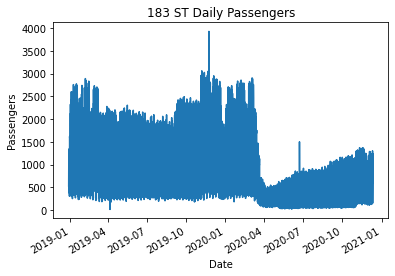

6 40 ST LOWERY ST


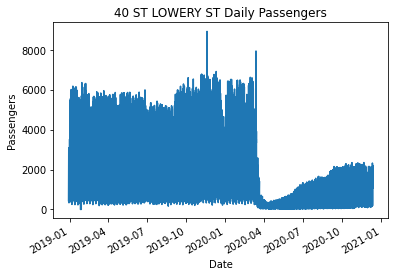

7 59 ST COLUMBUS


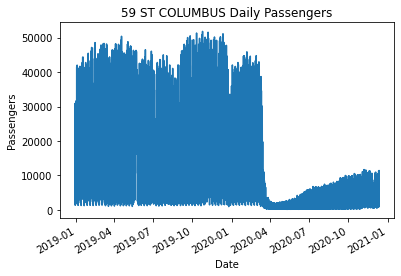

In [ ]:
df2 = pd.concat([pd.read_csv(file_prefix + "year" + str(2019) + file_suffix, parse_dates=[["DATE", "TIME"]], keep_date_col=True),
                 pd.read_csv(file_prefix + "year" + str(2020) + file_suffix, parse_dates=[["DATE", "TIME"]], keep_date_col=True)])
df2 = df2[df2["STATION"].apply(lambda x: x in stations or x == "BROOKLYN BRIDGE")]

df2 = df2.groupby(["STATION", "DATE_TIME"], as_index=False).agg(
    ENTRIES=pd.NamedAgg(column="ENTRIES", aggfunc=list),
    EXITS=pd.NamedAgg(column="EXITS", aggfunc=list),
    SCP=pd.NamedAgg(column="SCP", aggfunc=list))

df2 = df2[df2["DATE_TIME"].apply(lambda x: x.second == 0 and x.minute == 0)]

df3 = df2.set_index(["STATION", "DATE_TIME"], drop=False)
df3["ENTRIES_PREV"] = df3["ENTRIES"].shift(1)
df3["EXITS_PREV"] = df3["EXITS"].shift(1)
df3["SCP_PREV"] = df3["SCP"].shift(1)
df3["DATE_TIME_PREV"] = df3["DATE_TIME"].shift(1)

old_count = df2.shape[0]

df3 = df3[~df3.apply(lambda x: x["SCP_PREV"] == x["SCP"] and
                            (any(old > 0 and new > 1000 and (new-old)/old >= 2 for old, new in zip(x["ENTRIES_PREV"], x["ENTRIES"])) or
                            any(old > 0 and new > 1000 and (new-old)/old >= 2 for old, new in zip(x["EXITS_PREV"], x["EXITS"]))), axis=1)]

df3 = df3[df3.apply(lambda x: x["SCP_PREV"] == x["SCP"] and
                            all(new >= old for old, new in zip(x["ENTRIES_PREV"], x["ENTRIES"])) and
                            all(new >= old for old, new in zip(x["EXITS_PREV"], x["EXITS"])), axis=1)]

df3["ENTRIES"] = df3.apply(lambda x: sum(x["ENTRIES"]) - sum(x["ENTRIES_PREV"]), axis=1)
df3["EXITS"] = df3.apply(lambda x: sum(x["EXITS"]) - sum(x["EXITS_PREV"]), axis=1)
df3["PASSENGERS"] = df3["ENTRIES"] + df3["EXITS"]

print("Went from", old_count, "to", df3.shape[0], "entries")


plot_passengers(df3[(df3["STATION"] == "BROOKLYN BRIDGE") & (df3["DATE_TIME"] < pd.to_datetime("01/01/2020"))].set_index("DATE_TIME"),
                f"BROOKLYN BRIDGE Daily Passengers")
plt.show()

plot_passengers(df3[df3["STATION"] == "BROOKLYN BRIDGE"].set_index("DATE_TIME"),
                f"BROOKLYN BRIDGE Daily Passengers")
plt.show()

for station_i, station in enumerate(stations):
    try:
        print(station_i, station)
        plot_passengers(df3[df3["STATION"] == station].set_index("DATE_TIME"), f"{station} Daily Passengers")
        plt.show()
    except (TypeError, KeyError) as err:
        print("Exception:", err)

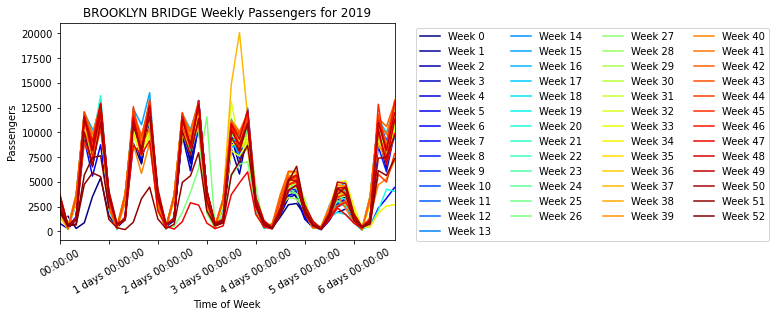

In [688]:
station = "BROOKLYN BRIDGE"
start = pd.to_datetime("01/01/2019")
end = pd.to_datetime("01/01/2020")
df4 = df3[(df3["DATE_TIME"] >= start) & (df3["DATE_TIME"] < end) & (df3["STATION"] == station)]
df4 = df4.droplevel("STATION")

# Round to the nearest 4 hours
df4["DATE_TIME"] = df4["DATE_TIME"].apply(lambda x: x + pd.Timedelta(hours=4 * ((x.hour+2) // 4) - x.hour))
df4 = df4.set_index("DATE_TIME")

x = df4.index

deltas = x - start
week = deltas.days // 7
week.name = None
deltas.name = None

d1 = pd.Series(
    df4["PASSENGERS"].values,
    [deltas - pd.to_timedelta(week, 'w'), week]
)

d2 = d1.unstack().add_prefix('Week ')

ax = d2.plot(rot=30, colormap='jet')
ax.legend(ncol=4, loc=2, bbox_to_anchor=(1.05, 1))
ax.set(xlabel="Time of Week", ylabel="Passengers", title=f"{station} Weekly Passengers for 2019")
ax.xaxis.set_major_locator(plt.MultipleLocator(60*60*24*1000*1000*1000))

Score: 0.07


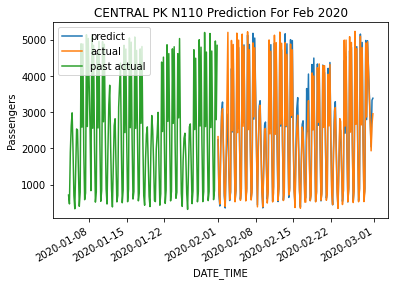

Average score: 0.07
Score: 3.89


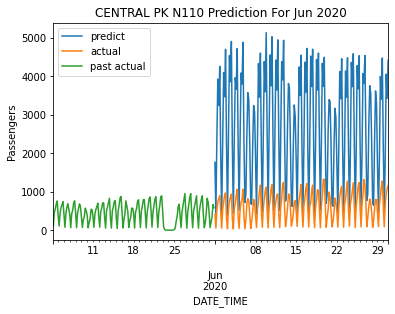

Average score: 3.89
Score: 1.67


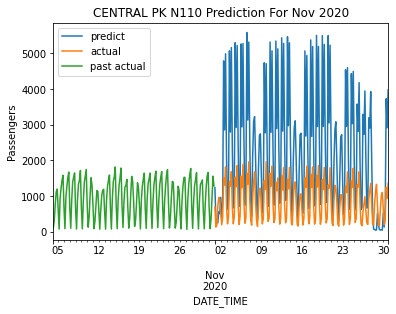

Average score: 1.67


In [ ]:
from sklearn.ensemble import RandomForestRegressor

FEB = "Feb 2020"
JUN = "Jun 2020"
NOV = "Nov 2020"

def extract_features(df, with_shift):
    df = df.droplevel("STATION")

    # Round to the nearest 4 hours
    df["DATE_TIME"] = df["DATE_TIME"].apply(lambda x: x + pd.Timedelta(hours=4 * ((x.hour+2) // 4) - x.hour))
    df = df.set_index("DATE_TIME")
    df = df[["PASSENGERS"]]

    df["HOUR"] = df.index.hour
    df["WEEKDAY"] = df.index.weekday
    df["MONTHDAY"] = df.index.day
    df["MONTH"] = df.index.month
    if with_shift:
        for shift in range(6, 48):
            df[f"SHIFTED_{shift}"] = df["PASSENGERS"].shift(shift)
    return df.dropna()

def model_and_predict(df, stations, date_str, with_shift):
    scores = []

    for station in stations:
        df2 = extract_features(df[df["STATION"] == station], with_shift)

        if date_str == FEB:
            mask_train = (df2.index >= pd.to_datetime("02/01/2019")) & (df2.index < pd.to_datetime("02/01/2020"))
            mask_test = (df2.index.year == 2020) & (df2.index.month == 2)
        elif date_str == JUN:
            mask_train = (df2.index >= pd.to_datetime("06/01/2019")) & (df2.index < pd.to_datetime("06/01/2020"))
            mask_test = (df2.index.year == 2020) & (df2.index.month == 6)
        elif date_str == NOV:
            mask_train = (df2.index >= pd.to_datetime("11/01/2019")) & (df2.index < pd.to_datetime("11/01/2020"))
            mask_test = (df2.index.year == 2020) & (df2.index.month == 11)
        X_train = df2[mask_train]
        y_train = X_train["PASSENGERS"]
        X_train = X_train.drop("PASSENGERS", axis=1)
        X_test = df2[mask_test]
        y_test = X_test["PASSENGERS"]
        X_test = X_test.drop("PASSENGERS", axis=1)

        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)

        result = pd.DataFrame({"predict": y_predict, "actual": y_test})
        result.plot(xlabel="Date", ylabel="Passengers", title=f"{station} Prediction For {date_str}")
        result["metric"] = abs(result["predict"] - result["actual"]) / result["actual"]
        score = sum(result["metric"]) / result.shape[0]
        scores.append(score)
        print(f"Score: {score:.2f}")
        past_actual = df2[(df2.index < y_test.index.min()) & (df2.index > y_test.index.min() - pd.Timedelta(weeks=4))]["PASSENGERS"]
        past_actual.name = "past actual"
        past_actual.plot(legend=True)
        plt.show()

    print(f"Average score: {np.mean(scores):.2f}")

station = next(iter(stations))

for date_str in [FEB, JUN, NOV]:
    model_and_predict(df3, [station], date_str, with_shift=False)

Score: 0.16


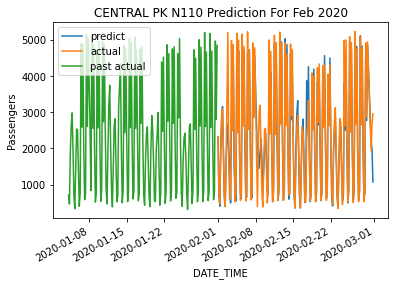

Score: 0.10


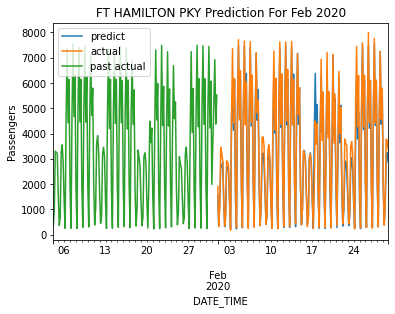

Score: 0.08


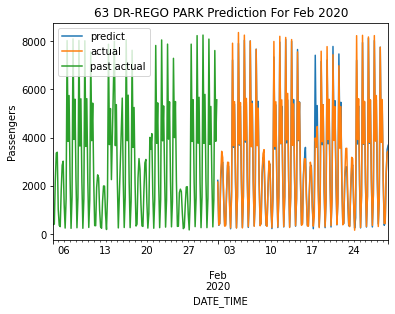

Score: 0.38


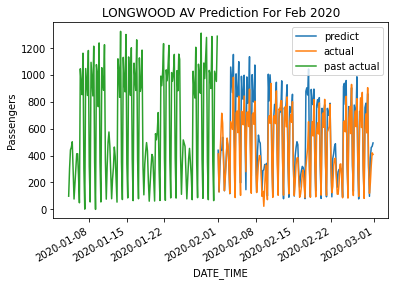

Score: 0.08


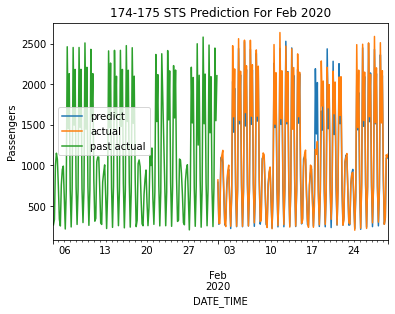

Score: 0.09


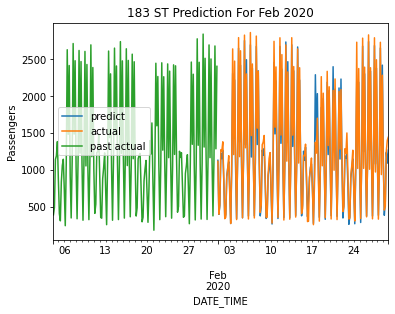

Score: 0.08


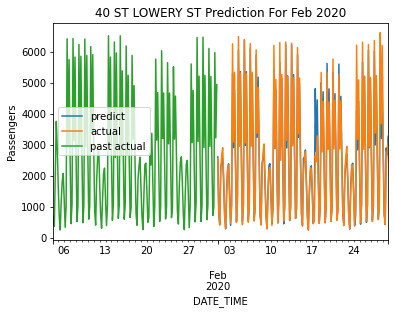

Score: 0.07


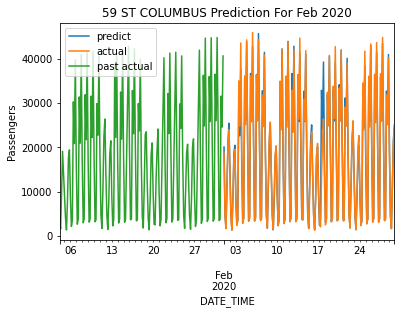

Average score: 0.13
Score: 0.23


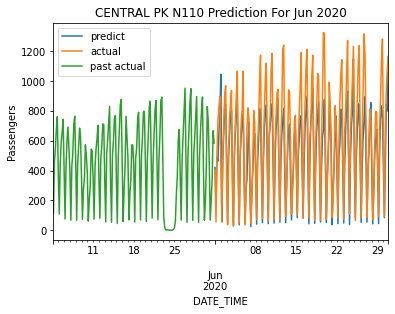

Score: 0.64


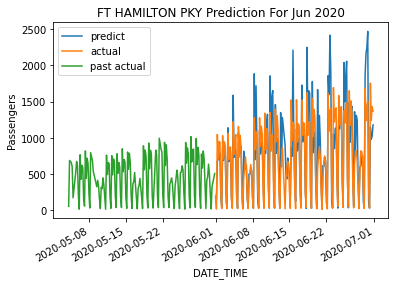

Score: 0.25


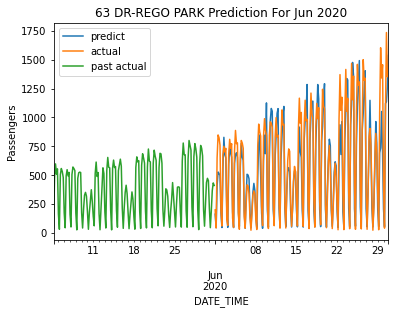

Score: 0.62


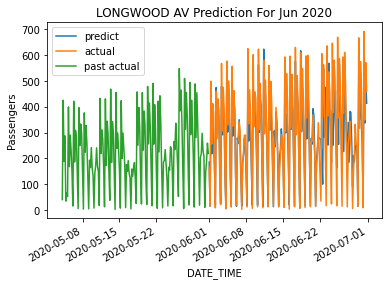

Score: 0.35


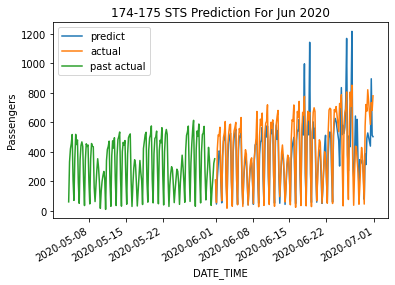

Score: 0.20


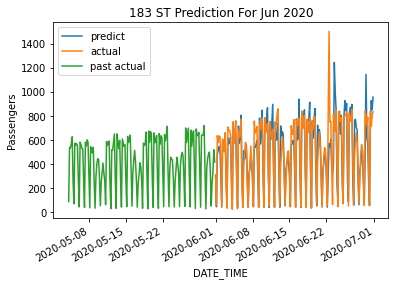

Score: 0.28


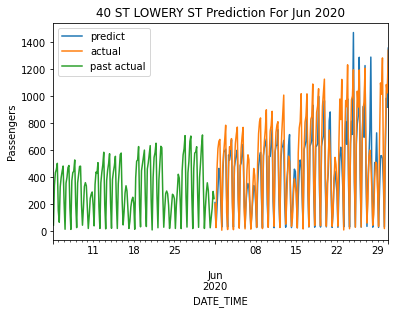

Score: 0.41


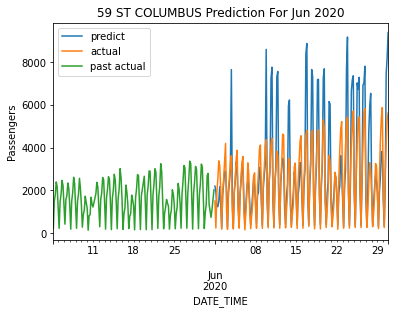

Average score: 0.37
Score: 0.28


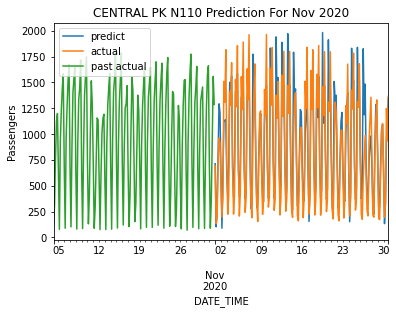

Score: 1.19


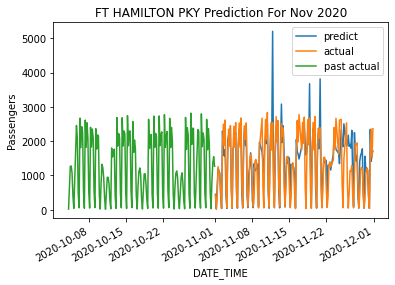

Score: 0.48


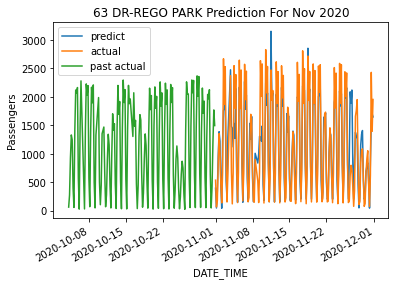

Score: 0.25


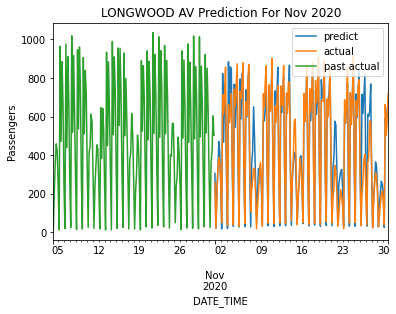

Score: 0.30


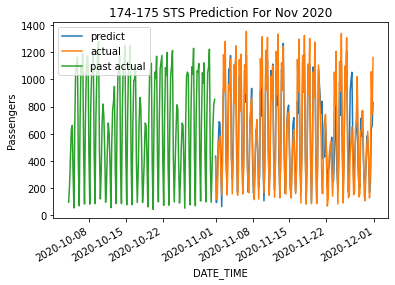

Score: 0.19


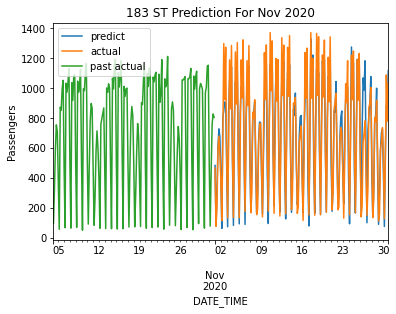

Score: 0.30


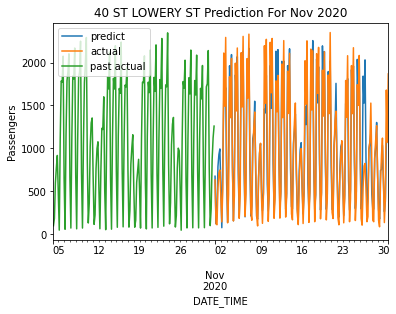

Score: 0.47


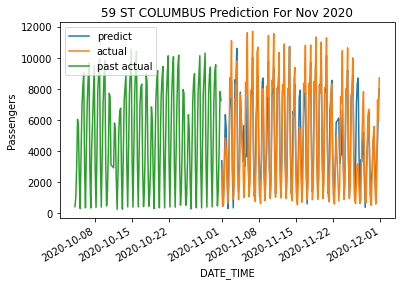

Average score: 0.43


In [742]:
for date_str in [FEB, JUN, NOV]:
    model_and_predict(df3, stations, date_str, with_shift=True)

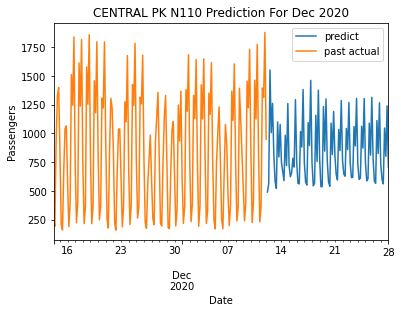

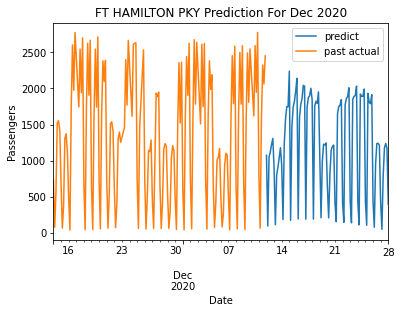

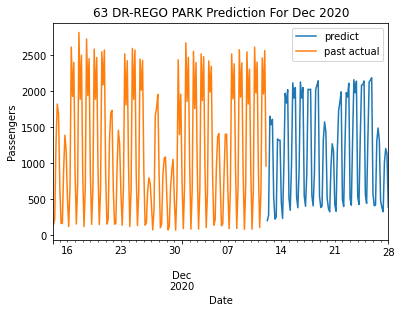

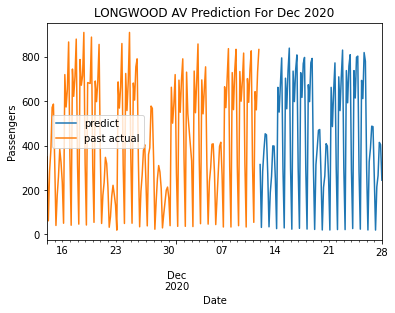

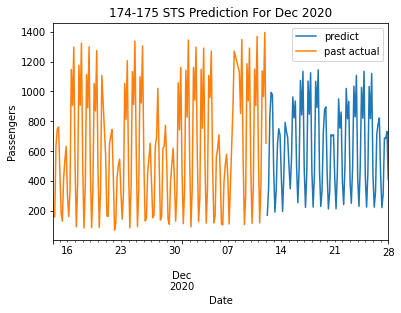

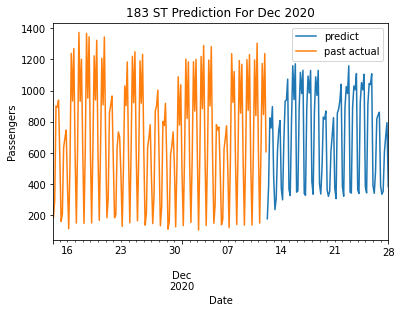

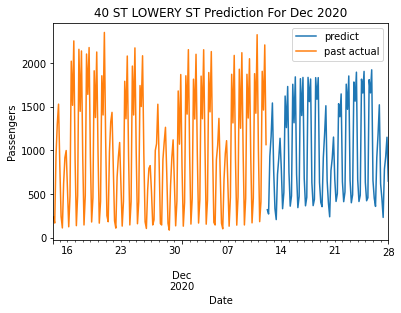

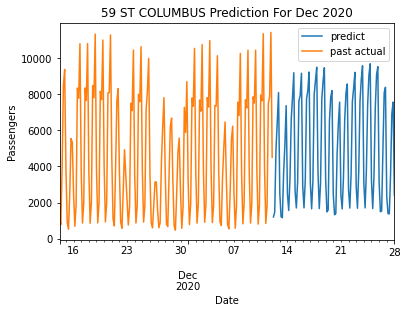

In [746]:
def model_and_predict_future(df):
    for station in stations:
        df2 = extract_features(df[df["STATION"] == station], with_shift=True)

        date_str = "Dec 2020"
        mask_train = (df2.index >= pd.to_datetime("11/01/2019")) & (df2.index < pd.to_datetime("11/01/2020"))
        X_train = df2[mask_train]
        y_train = X_train["PASSENGERS"]
        X_train = X_train.drop("PASSENGERS", axis=1)

        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)

        last_date = df2.index.max()
        while df2.index.max() < pd.to_datetime("12/28/2020"):
            time = df2.index.max() + pd.Timedelta(hours=4)
            data = [
                time.hour,
                time.weekday(),
                time.day,
                time.month
            ] + [np.roll(df2["PASSENGERS"], shift)[0] for shift in range(6, 48)]
            predicted = model.predict([data]).tolist()
            df2 = df2.append(pd.DataFrame([predicted + data], [time], df2.columns))

        result = pd.DataFrame({"predict": df2[df2.index > last_date]["PASSENGERS"]})
        result.plot(xlabel="Date", ylabel="Passengers", title=f"{station} Prediction For {date_str}")
        past_actual = df2[(df2.index <= last_date) & (df2.index > last_date - pd.Timedelta(weeks=4))]["PASSENGERS"]
        past_actual.name = "past actual"
        past_actual.plot(legend=True)
        plt.show()

model_and_predict_future(df3)